In [ ]:
import pathlib
import numpy as np
import imutils
from imutils.contours import sort_contours
import cv2
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls "/content/gdrive/MyDrive/assets"

'PPN337138764X_00000005 (1).jpg'   'PPN337138764X_00000005 (3).jpg'
'PPN337138764X_00000005 (26).jpg'  'PPN337138764X_00000005 (4).jpg'
'PPN337138764X_00000005 (2).jpg'   'PPN337138764X_00000005 (5).jpg'
'PPN337138764X_00000005 (38).jpg'  'PPN3371387720_00000004 (2).jpg'


The following notebook demonstrates a basic segmentation of tibetan numbers that are always located on the left side of the page. Segmentation can be enhanced by changing the dilation based on the font size of the text. For generating synthetic data it is useful to consider the transformations of cropped grey-inverse images. 

In [23]:
def crop_image(cv2_image):
    # Get the dimensions of the image
    image=cv2_image.copy()
    height, width = image.shape[:2]
    # Define the bounding box (left 16% of the image)
    left_x = 0
    right_x = int(width * 0.16)
    top_y = 0
    bottom_y = height

    # Crop the image to the bounding box
    cropped_image = image[top_y:bottom_y, left_x:right_x]
    plt.imshow(cropped_image, cmap='gray')
    plt.title("Cropped image")
    plt.show()
    return cropped_image

In [24]:
#Get the inversion of the image in grey-scale
def inverse_grey(cv2_image, image_name):
    gray = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray.copy(), 150, 255, cv2.THRESH_BINARY_INV)
    grey_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,1))
    grey_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, grey_kernel)
    plt.imshow(grey_image, cmap='gray')
    plt.title(f"Grey Inversion of {image_name}")
    plt.show()
    return grey_image

In [25]:
#Erode noise on the image
def erode_noise(grey_image, image_name):
    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,1))
    eroded_image = cv2.erode(grey_image.copy(),erosion_kernel,iterations = 1)
    plt.imshow(eroded_image, cmap='gray')
    plt.title(f"Noise erotion of {image_name}")
    plt.show()
    return eroded_image

In [38]:
#Dilate the text on the image
def dilate_text(eroded_image, image_name):
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (70,20))
    dilated_image = cv2.dilate(eroded_image.copy(), dilate_kernel, iterations = 1)
    plt.imshow(dilated_image, cmap='gray')
    plt.title(f"Text dilation of {image_name}")
    plt.show()
    return dilated_image

In [27]:
#Function for text segmentation
def segment_text(dilated_image, image_name):
    edged_image = cv2.Canny(dilated_image.copy(), 30, 100)
    plt.imshow(edged_image, cmap='gray')
    plt.show()
    cnts = cv2.findContours(edged_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    bounding_boxes = []
    for c in cnts:
       (x, y, w, h) = cv2.boundingRect(c)
       bounding_boxes.append((x, y, w, h))
    image_data = {image_name: np.array(bounding_boxes)}
    return image_data, bounding_boxes

In [28]:
def illustrate_segmentation(cv2_image, cropped_image, image_name, bounding_boxes):
    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(cv2_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(cropped_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.imshow(cv2_image)
    plt.title(f"Segmentation of {image_name}")
    plt.show()
    plt.imshow(cropped_image)
    plt.title(f"Segmentation of cropped {image_name}")
    plt.show()
    cv2.waitKey(0)
    return cropped_image, cv2_image

In [ ]:
def process_cropped_image(image_path):
    image_dir=pathlib.Path(image_path)
    image_files = list(image_dir.glob("*.jpg"))
    array_cropped_images = []
    array_grey_images = []
    array_dilated_images = []
    array_bounding_boxes = []
    array_segmented_cropped_images = []
    array_segmented_images = []
    dict_bounding_boxes = {}

    for image in image_files:
        cv2_image = cv2.imread(str(image))
        cropped_image=crop_image(cv2_image)
        grey_image = inverse_grey(cropped_image, image.name)
        eroded_image= erode_noise(grey_image, image.name)
        dilated_image = dilate_text(eroded_image, image.name)
        dict_image_bounding_box, bounding_boxes=segment_text(dilated_image, image.name)
        segmented_cropped_image, segmented_image=illustrate_segmentation(cv2_image, cropped_image, image.name, bounding_boxes)

        #Write transformations into numpy arrays
        array_cropped_images.append(cropped_image)
        array_grey_images.append(grey_image)
        array_dilated_images.append(dilated_image)
        array_bounding_boxes.append(bounding_boxes)
        dict_bounding_boxes.update(dict_image_bounding_box)
        array_segmented_cropped_images.append(segmented_cropped_image)
        array_segmented_images.append(segmented_image)

    return image_files, array_cropped_images, array_grey_images, array_dilated_images, array_bounding_boxes, array_segmented_cropped_images, array_segmented_images, dict_bounding_boxes

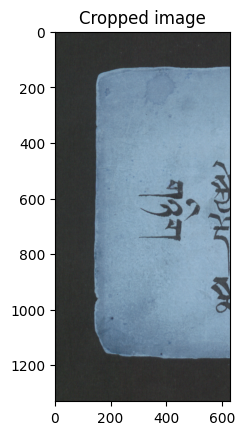

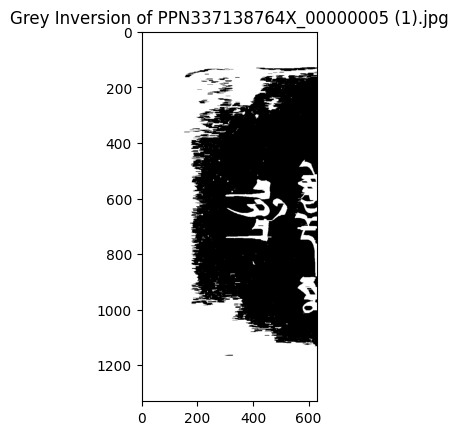

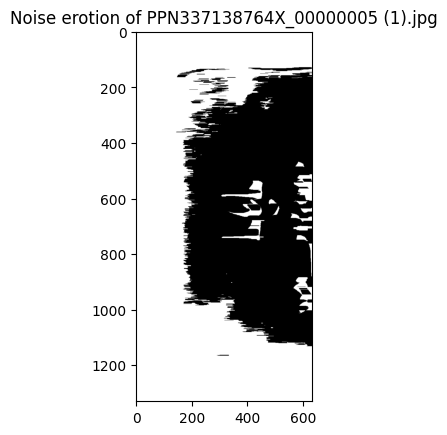

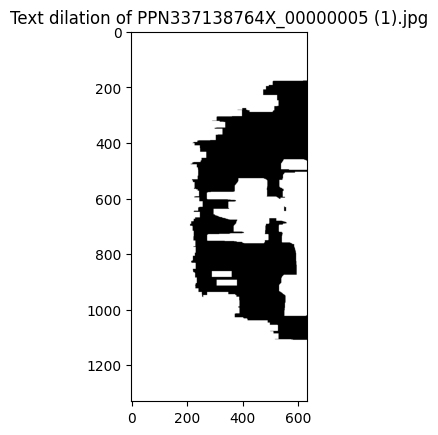

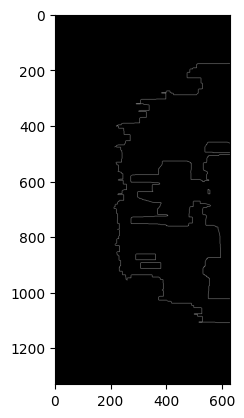

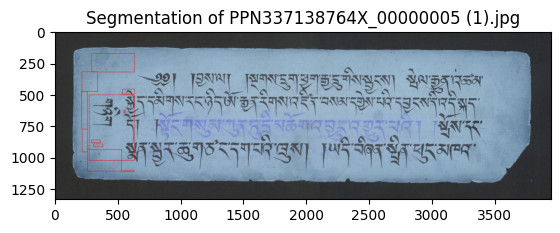

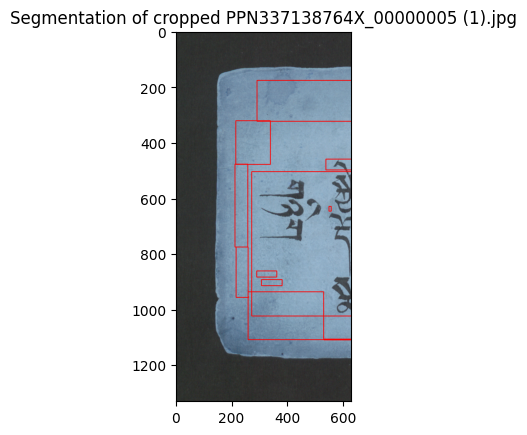

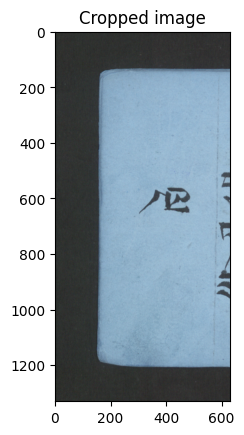

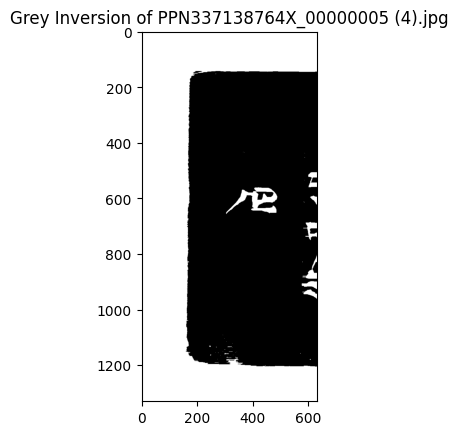

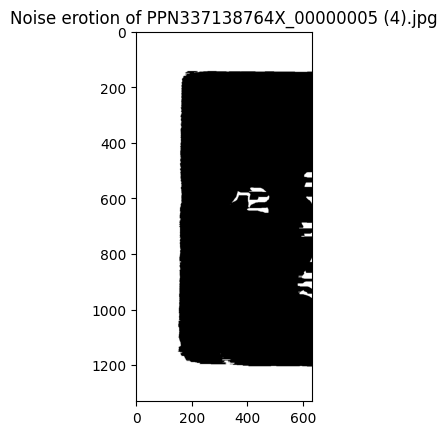

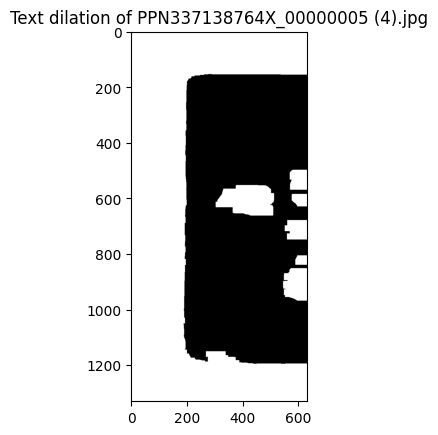

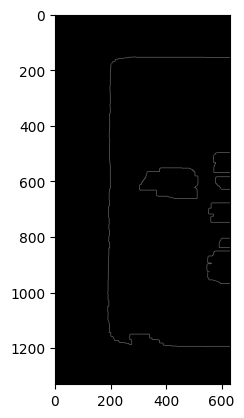

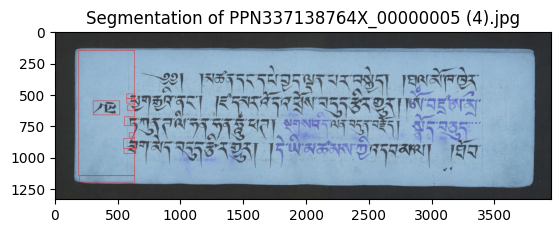

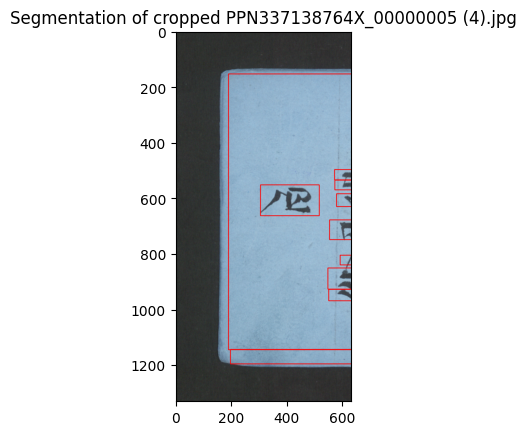

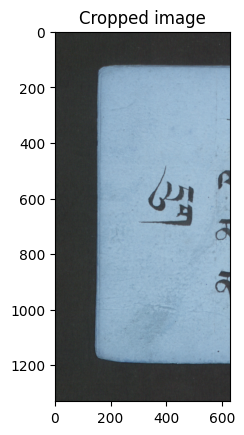

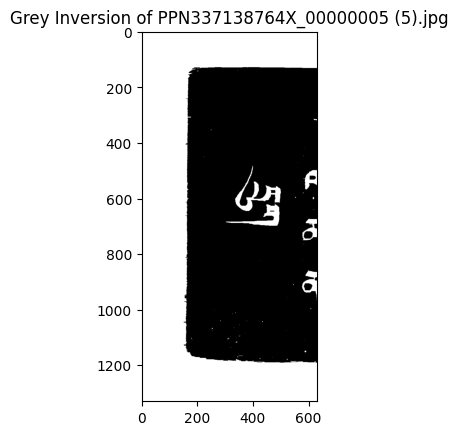

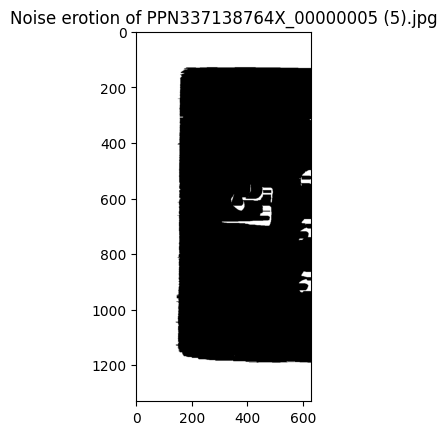

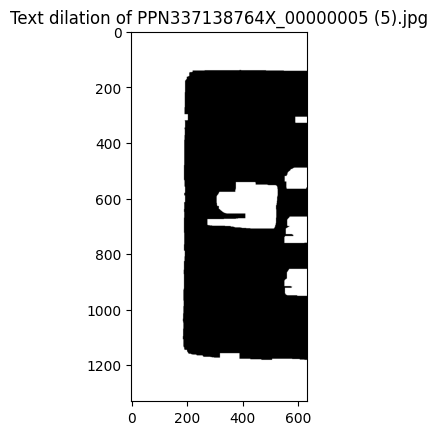

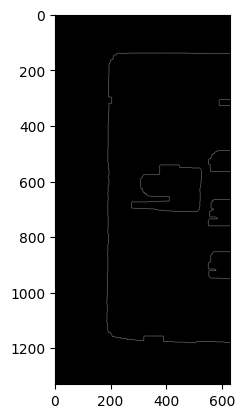

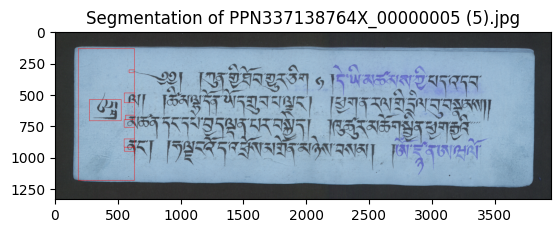

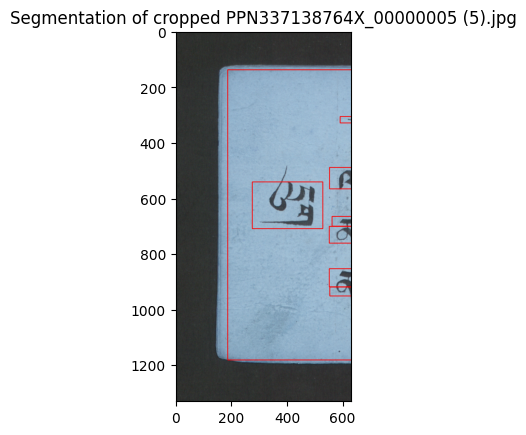

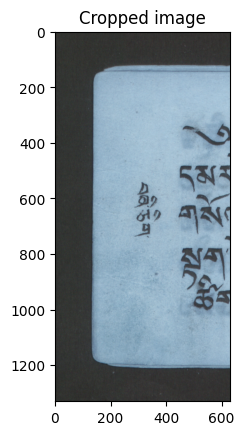

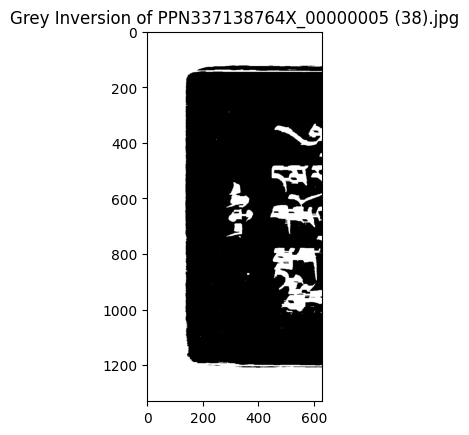

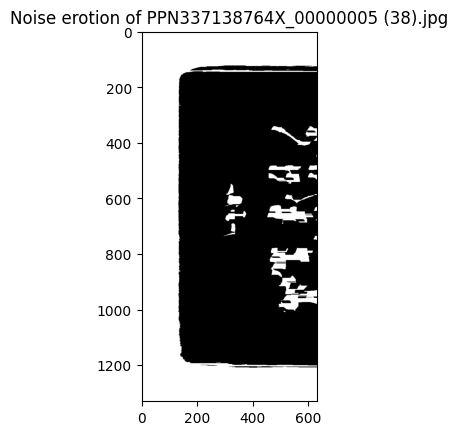

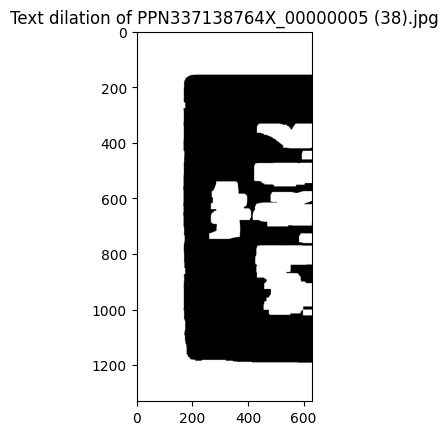

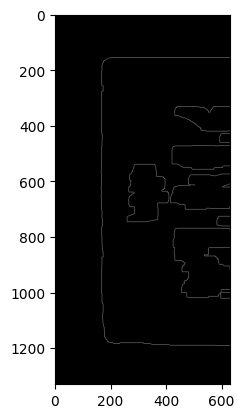

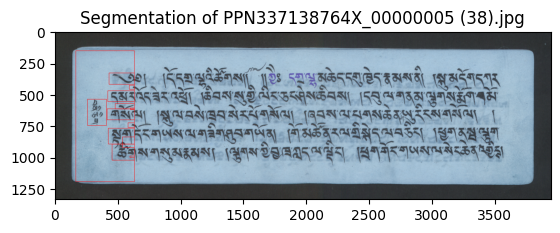

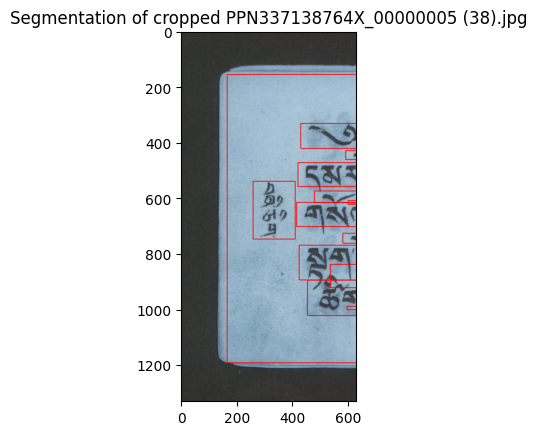

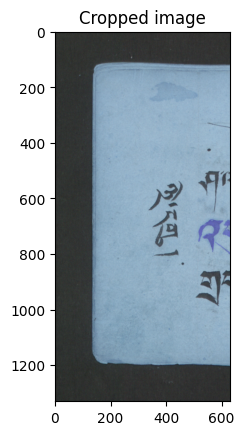

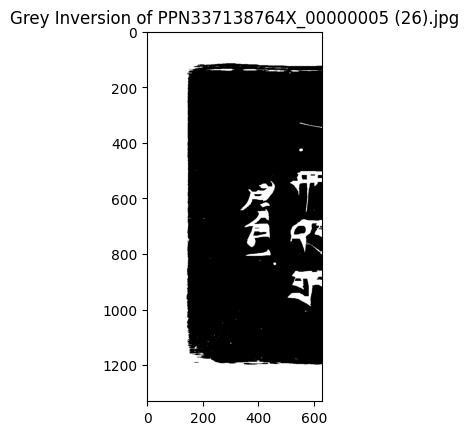

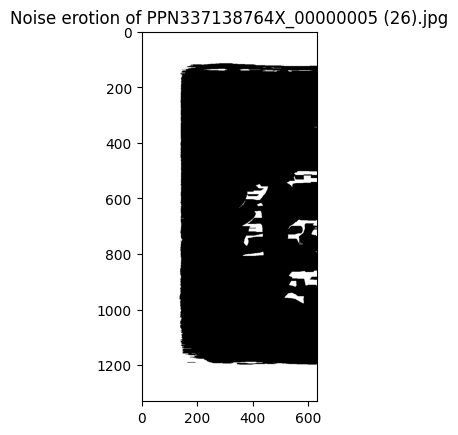

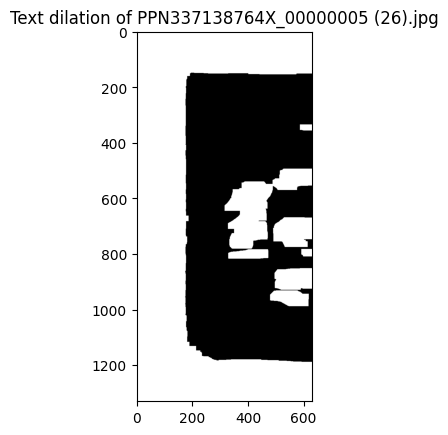

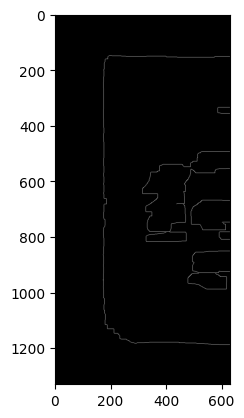

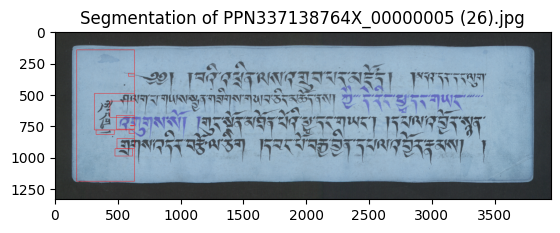

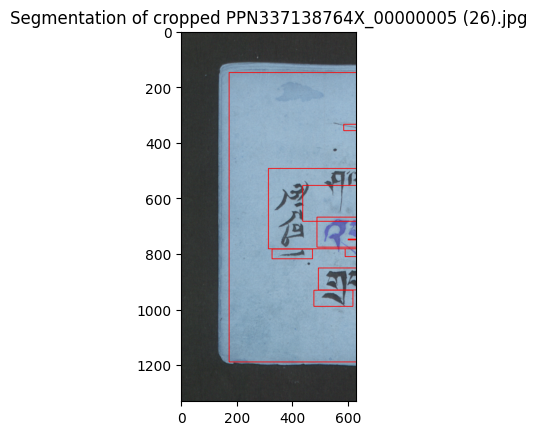

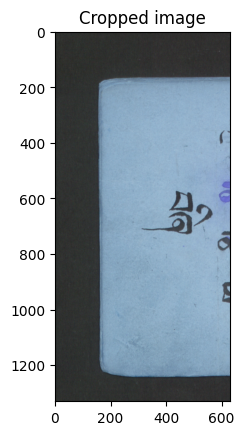

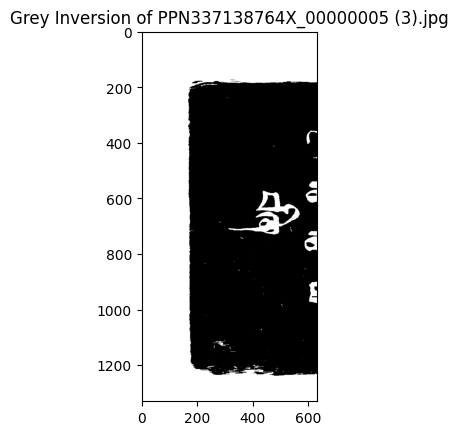

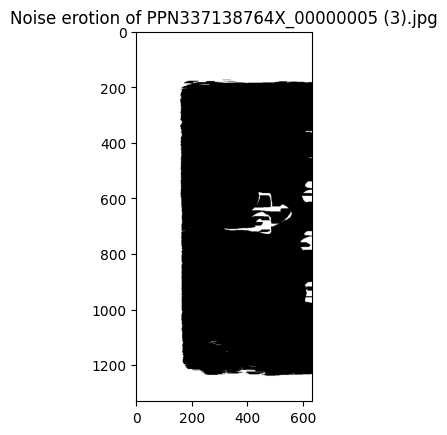

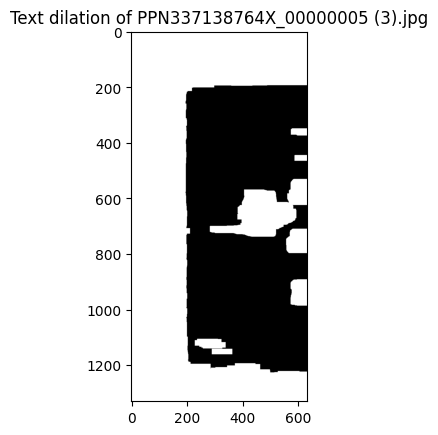

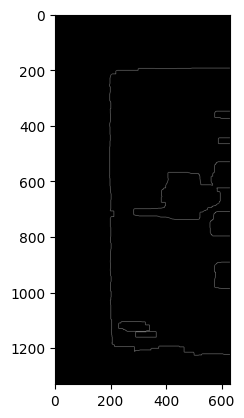

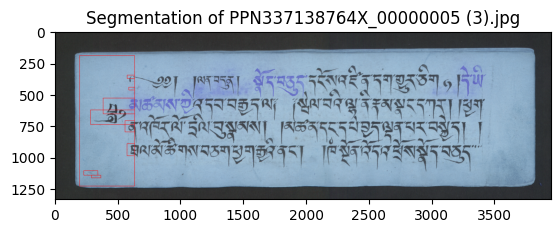

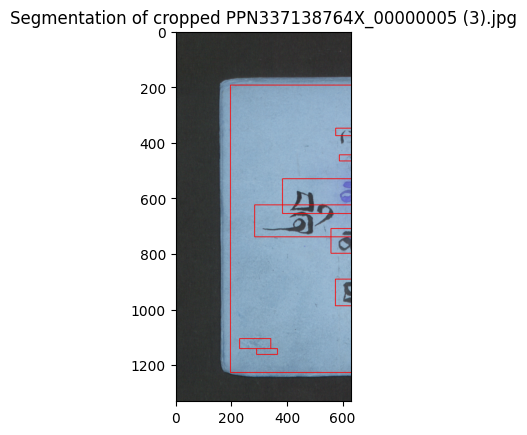

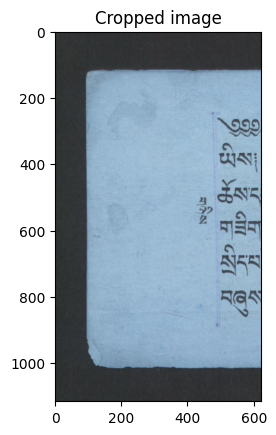

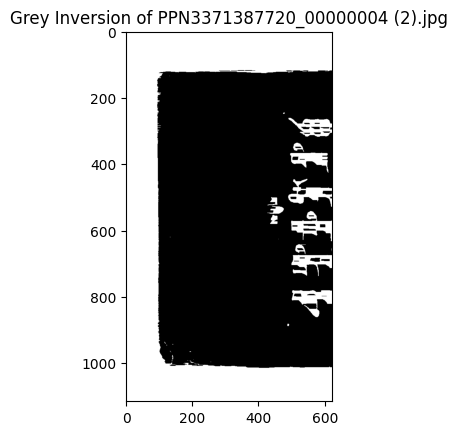

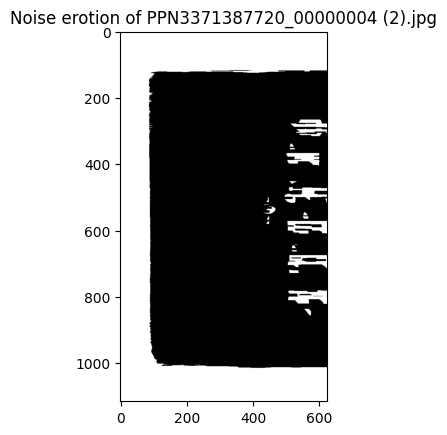

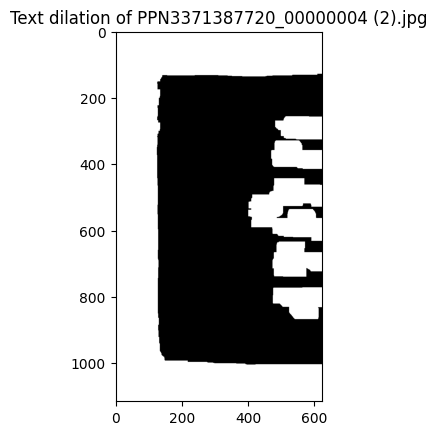

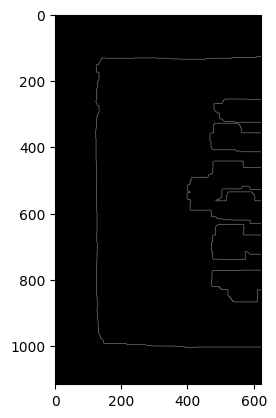

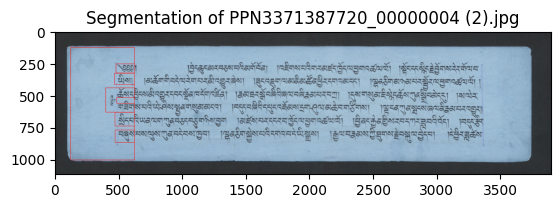

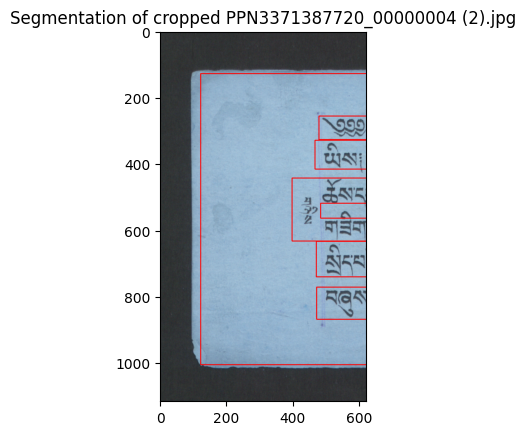

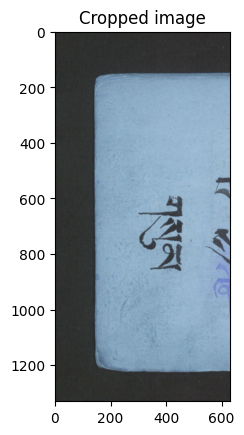

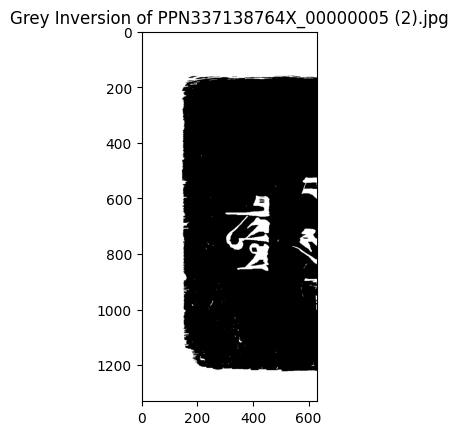

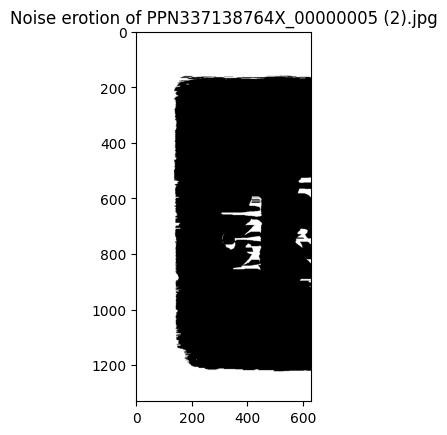

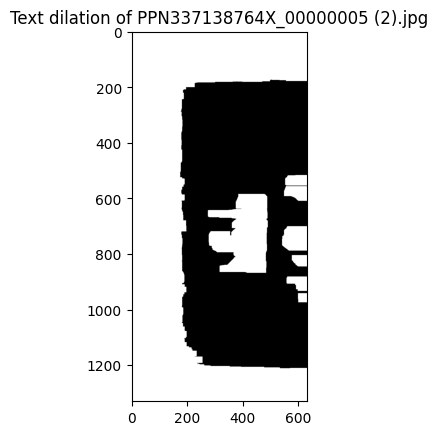

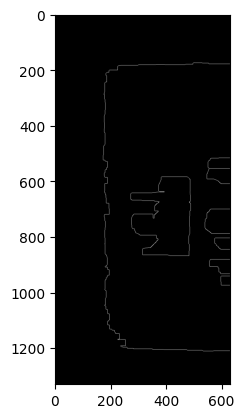

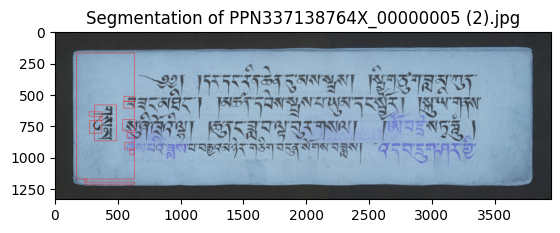

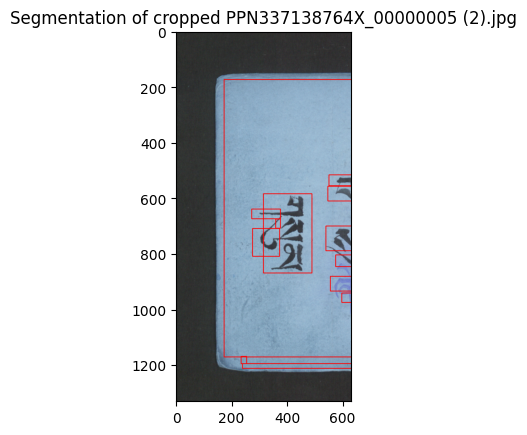

In [39]:
image_files, array_cropped_images, array_grey_images, array_dilated_images, array_bounding_boxes, array_segmented_cropped_images, array_segmented_images, dict_bounding_boxes=process_cropped_image('/content/gdrive/MyDrive/assets/')